### NN Vector Pull for Direction

Fig 4a - cosine angle of updates analysis

##### Summary
Load any NN model. Obtain layer by layer the unit direction vector (against vector of zeros). See if cosine similarity can be used as a metric to measure direction.

In [1]:
cd /home/ubuntu/fedatk_unl_tj/

/home/ubuntu/fedatk_unl_tj


In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from utils.util_notebooks import *
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *

In [16]:
setting, num_user = "FedAvg_adv", 40

try: # Skip loading if already loaded
    aggregator
except:
    aggregator, clients, args_ = set_args(setting, num_user,  experiment = "cifar10") # Indicate dataset here

# Load models for FAT and FedAvg
save_path_FAT = '/home/ubuntu/fedatk_unl_tj/weights/cifar10/231031_FAT150round/FAT/'
save_path_FedAvg = '/home/ubuntu/fedatk_unl_tj/weights/cifar10/230922_baseline_train/fedavg/'

model_FAT = copy.deepcopy(import_model_weights(num_user, setting, save_path_FAT, aggregator, args_)[0])
model_Fedavg = import_model_weights(num_user, setting, save_path_FedAvg, aggregator, args_)[0]


/home/ubuntu/fedatk_unl_tj/aggregator.py:288: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  learner.model.load_state_dict(torch.load(chkpts_path))


In [17]:
from sklearn.metrics.pairwise import cosine_similarity

def matrix_cosine_similarity(mat1, mat2):
    vec1 = mat1.cpu().numpy().flatten()
    vec2 = mat2.cpu().numpy().flatten()
    return cosine_similarity([vec1], [vec2])[0][0]

def get_diff_NN( model1, model2, desired_keys):

    param_model1 = model1.state_dict()
    param_model2 = model2.state_dict()

    mag_norm_122 = []
    for key in desired_keys: #params_FAT:

        diff = param_model1[key] - param_model2[key]
        l2_norm = torch.norm(diff, p=2)

        mag_norm_122 += [diff/torch.norm(diff,p=2)]
    return mag_norm_122

def diff_cosine_similarity(diff, baseline, key_length):
    values_stored = np.zeros(key_length)

    for i in range(key_length):
        values_stored[i] = matrix_cosine_similarity(diff[i], baseline[i])

    return values_stored 

def get_adv_acc(aggregator, model, batch_size = 500, data_mode = "all", c_id = 0):
    num_clients = len(aggregator.clients)

    # Dataloader for datax
    data_x = []
    daniloader = clients[0].val_iterator
    for (x,y,idx) in daniloader.dataset:
        data_x.append(x)

    data_x = torch.stack(data_x)
    victim_idxs = range(num_clients)

    # Save matrix
    test_acc_save = np.zeros([1])
    adv_acc_save = np.zeros([1])

    dataloader = load_client_data(clients = aggregator.clients, c_id = c_id, mode = data_mode)
    batch_size = min(batch_size, dataloader.y_data.shape[0])

    t1 = Transferer(models_list = [model] * num_clients, dataloader=dataloader)
    t1.generate_victims(victim_idxs)
    t1.atk_params = PGD_Params()
    t1.atk_params.set_params(batch_size=batch_size, iteration = 10, target = -1,
                            x_val_min = torch.min(data_x), x_val_max = torch.max(data_x),
                            step_size = 0.05, step_norm = "inf", eps = 4, eps_norm = 2)
    t1.generate_advNN(c_id)
    t1.generate_xadv(atk_type="pgd")
    t1.send_to_victims(victim_idxs)
    test_acc_save[0] = t1.orig_acc_transfers[0]
    adv_acc_save[0] = t1.adv_acc_transfers[0]

    return test_acc_save, adv_acc_save

def pull_model_from_agg(aggregator):
        
    # This is where the models are stored -- one for each mixture --> learner.model for nn
    hypotheses = aggregator.global_learners_ensemble.learners

    # obtain the state dict for each of the weights 
    weights_h = []

    for h in hypotheses:
        weights_h += [h.model.state_dict()]
    
    # first make the model with empty weights
    new_model = copy.deepcopy(hypotheses[0].model)
    return new_model

In [18]:
# Obtain parameters for each layer
params_FAT = model_FAT.state_dict()
params_FedAvg = model_Fedavg.state_dict()

# Just take the values of weights and bias for the model
desired_keys = [key for key in params_FAT.keys() if 'weight' in key or 'bias' in key]

In [19]:
# Find mag norm 
mag_norm_FedAvg2FAT = []
for key in desired_keys: #params_FAT:

    diff = params_FAT[key] - params_FedAvg[key]
    l2_norm = torch.norm(diff, p=2)

    mag_norm_FedAvg2FAT += [diff/torch.norm(diff,p=2)]


In [20]:
# Perform 50 rounds of full overfitting on benign data on 200R FAT model
num_rounds = 20

setting = 'FedAvg_adv'

test_acc_gather = []
adv_acc_gather = []
cosine_gather_layers = np.zeros([num_rounds, len(desired_keys)])

save_path_FAT150 = 'weights/cifar10/231031_FAT150round/FAT/'

aggregator, clients, args_ = set_args(setting, num_user)

# Test performance of aggregator on data 
aggregator.load_state(dir_path = save_path_FAT150)
aggregator.update_clients()
model_FAT = pull_model_from_agg(aggregator)
model_FAT.eval()
acc, adv_acc = get_adv_acc(aggregator, model_FAT)

prev_model = copy.deepcopy(model_FAT)

print("Test acc: ", np.mean(acc), "adv acc: ", np.mean(adv_acc))
test_acc_gather+= [np.mean(acc)]
adv_acc_gather += [np.mean(adv_acc)]

# Setting evasion attack parameters
x_min = torch.min(clients[0].adv_nn.dataloader.x_data)
x_max = torch.max(clients[0].adv_nn.dataloader.x_data)
atk_params = PGD_Params()
atk_params.set_params(batch_size=1, iteration = 10,
                target = -1, x_val_min = x_min, x_val_max = x_max,
                step_size = 0.05, step_norm = "inf", eps = 4.5, eps_norm = 2)


for i in range(num_rounds):
    # if i%2 == 0: # UNCOMMENT IF ADDING FAT PROCEDURE TO CALCULATION
    #     # add adv dataset update
    #     G = 0.5
    #     Fu = np.ones(num_user) * G

    #     # Assign proportion and attack params
    #     for c in range(len(clients)):
    #         aggregator.clients[c].set_unhard(unhard = True, unharden_portion = 0.5)
    #         aggregator.clients[c].set_adv_params(Fu[c], atk_params)
    #         aggregator.clients[c].update_advnn()
    #         aggregator.clients[c].assign_advdataset()

    aggregator.mix()
    model_overfit = pull_model_from_agg(aggregator)
    model_overfit.eval()
    acc, adv_acc = get_adv_acc(aggregator, model_overfit)

    diffnn = get_diff_NN(prev_model, model_overfit, desired_keys)

    cosine_gather_layers[i,:] = diff_cosine_similarity(diffnn, mag_norm_FedAvg2FAT, len(desired_keys))
    print("round", i,"Test acc: ", np.mean(acc), "adv acc: ", np.mean(adv_acc))
    test_acc_gather+= [np.mean(acc)]
    adv_acc_gather += [np.mean(adv_acc)]
    prev_model = copy.deepcopy(model_overfit)
    # Perform gradient direction gathering




==> Clients initialization..
===> Building data iterators..


 49%|████▉     | 39/80 [00:00<00:00, 209.37it/s]


===> Initializing clients..


  0%|          | 0/40 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 40/40 [00:15<00:00,  2.58it/s]


Test acc:  0.7620000243186951 adv acc:  0.320000022649765
round 0 Test acc:  0.7860000133514404 adv acc:  0.3460000157356262
round 1 Test acc:  0.8360000252723694 adv acc:  0.28200000524520874
round 2 Test acc:  0.8160000443458557 adv acc:  0.23600001633167267
round 3 Test acc:  0.7920000553131104 adv acc:  0.2160000056028366
round 4 Test acc:  0.8280000686645508 adv acc:  0.23800000548362732
round 5 Test acc:  0.8440000414848328 adv acc:  0.25200000405311584
round 6 Test acc:  0.7980000376701355 adv acc:  0.20800000429153442
round 7 Test acc:  0.8240000605583191 adv acc:  0.21800000965595245
round 8 Test acc:  0.8320000171661377 adv acc:  0.23600001633167267


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.58 GiB of which 15.81 MiB is free. Including non-PyTorch memory, this process has 13.01 GiB memory in use. Process 22849 has 1.54 GiB memory in use. Of the allocated memory 12.73 GiB is allocated by PyTorch, and 147.48 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

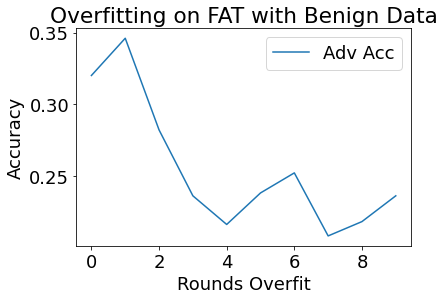

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
x = range(len(test_acc_gather))  # 100 points from 0 to 10
y1 = test_acc_gather               # Sine function for the first line
y2 = adv_acc_gather             # Cosine function for the second line

# Plotting the lines
# plt.plot(x, y1, label='Test Acc')
plt.plot(x, y2, label='Adv Acc')

# Adding labels and title
plt.xlabel('Rounds Overfit')
plt.ylabel('Accuracy')
plt.title('Overfitting on FAT with Benign Data')

# Adding a legend
plt.legend()

# Display the plot
plt.show()


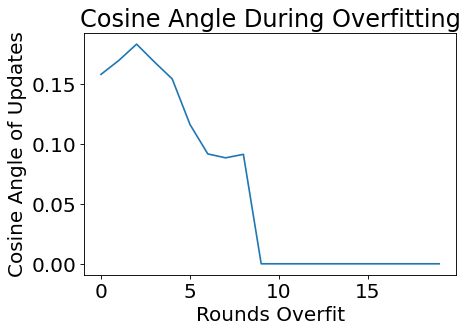

In [22]:
np.mean(cosine_gather_layers,axis = 1)

import matplotlib.pyplot as plt
import numpy as np

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)
plt.figure(dpi=80, figsize=(6,4))

# Generate some sample data
y1 = np.mean(cosine_gather_layers,axis = 1)
x = range(len(y1))  # 100 points from 0 to 10


# Plotting the lines
plt.plot(x, y1)

# Adding labels and title
plt.xlabel('Rounds Overfit')
plt.ylabel('Cosine Angle of Updates')
plt.title('Cosine Angle During Overfitting')

# Adding a legend
# plt.legend()

# Display the plot
plt.show()


In [23]:
# Get number of params per desired key
size = np.zeros(len(desired_keys))
i = 0
for key in desired_keys:
    size[i]=params_FAT[key].flatten().shape[0]
    i += 1

prop = size/np.sum(size)

cosine_propped = np.zeros(cosine_gather_layers.shape)

# for t in range(num_rounds):
#     cosine_propped[t,:] = np.average(cosine_gather_layers[t,:], weights = prop)

np.average(cosine_gather_layers, weights = prop, axis = 1)

array([0.08, 0.09, 0.09, 0.09, 0.08, 0.05, 0.03, 0.03, 0.02, 0.00, 0.00,
       0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00])

Text(0.5, 1.0, 'Per Layer Cosine Angle Round 1')

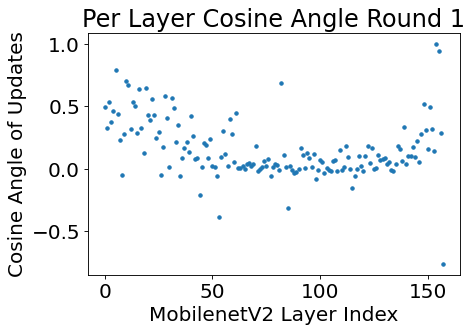

: 

In [ ]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)
plt.figure(dpi=80, figsize=(6,4))

plt.plot(cosine_gather_layers[0],'.')

# Adding labels and title
plt.xlabel('MobilenetV2 Layer Index')
plt.ylabel('Cosine Angle of Updates')
plt.title('Per Layer Cosine Angle Round 1')